# UNDERSTANDING GNN EXPLAINER


GNN Explainer is a method used to explain the predictions made by Graph Neural Networks (GNNs) that was introduced in [https://arxiv.org/pdf/1903.03894.pdf]. 
GNNs are a type of neural network used for processing graph-structured data, and they have shown impressive performance in various domains such as social network analysis, chemistry, and recommendation systems. However, understanding how GNNs make predictions can be challenging due to their complex structure and the lack of transparency in their decision-making process.

GNN Explainer provides an intuitive explanation of the predictions made by GNNs by highlighting the most relevant nodes and edges in the input graph. It works by using a secondary GNN model, called the explainer, which is trained to predict the importance of each node and edge in the input graph. The explainer model can then generate an explanation graph, which is a simplified version of the original input graph, highlighting the most important nodes and edges based on their importance scores.

The explanation graph generated by GNN Explainer can help users understand why a particular prediction was made by the GNN model and can also aid in identifying potential biases or errors in the GNN model's predictions.

## Scope of this tutorial

In this tutorial we are going to explore how GNN Explainer works by breaking it down in pieces, as to make it more intuitevely understandable.

We will work on the Cora dataset to show all the steps involved, and the model that we will explain is a small GCN model.


## Steps
The Explain module of GNNExplainer comprises of two main classes: ExplainModule (nn.Module where the Explainer model is defined) and Explainer (Where the Explainer model is called for training)

### Explainer
Given a node index for which we want to explain the model's node classification, the masked adjacency matrix - whose weights represent the relation importance - are returned.

#### Steps
1. Extract the neighborhood of the given node: this is done
2. Get the original label of the node
3. Get the predicted label of the node (argmax from the softmax layer of the network)
4. Call the ExplainModule for the training of the Explainer Model



## ExplainModule

In [1]:
#Here we import the necessary libraries
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm import tqdm

#for the model 
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import matplotlib.pyplot as plt

#Explain Module
import torch.nn as nn
import math

#to import the data
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import to_networkx

### Import the dataset 

In [2]:
#Here we import the Cora dataset. We use the Cora dataset because it is a small dataset and it is easy to understand.
#We import the dataset from the Pytorch Geometric library as it is already preprocessed - and the goal is then to further expand the GNN implementation to other datasets starting from the PYG implementation.

#import the dataset and print some information about it
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]
print('dataset under study')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')

#for convention to how things are named we rename the data
label = data.y
feat = data.x

Number of graphs: 1
Number of features: 1433
Number of classes: 7
dataset under study
Number of nodes: 2708
Number of edges: 10556


Since we want to visualize the graph, we need to convert the data into a networkx graph. We can then use the networkx library to visualize the graph. Each node color represents a different class in the dataset.

In [3]:

G = to_networkx(data, to_undirected=True)
#nx.draw(G, with_labels=False, node_color=data.y)

Another cool thing about importing our graph into a networkx object is that we can easily extract its adjacency matrix - which we will need to dig into the GNN Explainer method.

We can easily see from the Adjacency matrix that the graph is directed as adj is not symmetric, but indeed as it should be is a square matrix.

Just a reminder: what is an Adjacency matrix of a graph?

It is a matrix where each row correspond to a node, and the row/column combination represent the connectivity between two nodes. 
In particular for node 1, we can see that it has a connection towards node 2, because it is a non zero element of the node 1 row.


In [4]:
adj = nx.adjacency_matrix(G).todense()
print('Connectivity for node 1: \n we can see that it is connected to node 2',adj[1][0:10])

Connectivity for node 1: 
 we can see that it is connected to node 2 [0 0 1 0 0 0 0 0 0 0]


1. Extract the neighborhood of the given node
- We are interested in getting a neighborhood not just in terms of actual neighbors but also in terms of potentian neighbors - namely node which are not directly connected but they would be connected if we consider a different number of hops.

- For instance in a simple graph a-b-c: a is connected to c if we consider 2 hops.

- We want to have a function that gets that for all our graph - so we rely on the adjacency matrix and we modify it according to the number of hops that we want to take into consideration.

- We add self loops as well in terms of connections

#from graph_utils import neighborhoods

In [6]:
#line 147 in utils/graph_utils.py
def neighborhoods(adj, n_hops):
    """Returns the n_hops degree adjacency matrix adj."""

    adj = torch.tensor(adj, dtype=torch.float)
    hop_adj = power_adj = adj
    for i in range(n_hops - 1):
        power_adj = power_adj @ adj
        prev_hop_adj = hop_adj
        hop_adj = hop_adj + power_adj
        #print(type(hop_adj))
        hop_adj = (hop_adj > 0).float()
        #print(hop_adj)
    return hop_adj.cpu().numpy().astype(int)
n_hops = 2
adj_hop = neighborhoods(adj, n_hops)
print(f' {n_hops} hops Connectivity for node 1: \n we can see that it is connected to node 2',adj_hop[1,:])


 2 hops Connectivity for node 1: 
 we can see that it is connected to node 2 [0 1 1 ... 0 0 0]


### Extract neighborhood
We are simplifying the function as we are working with 1 graph only (indeed we are working on node mode)

Extract neighborhood which returns the new index node, the adjacency matrix of the neighboor, the features of the neighboor, the label and the actual neighbors.


- So the neighbors are indeed the neighbros as defined to be the neighbors according to the number of hops used
- the sub adj: is the adjacency matrix of the neighbors (adjacency where select only row and cols of the neighbor ) -- thus its size depends on how many neighbors the node has
- new index usually just zero

In [24]:
#line 506 in explain.py

def extract_neighborhood(node_idx,adj,feat,label,n_hops):
    """Returns the neighborhood of a given ndoe."""
    neighbors_adj_row = neighborhoods(adj,n_hops)[node_idx, :] #take row of the node in the new adj matrix
    # index of the query node in the new adj
    node_idx_new = sum(neighbors_adj_row[:node_idx]) #sum of all the nodes before the query node (since they are 1 or 0) - it becomes count of nodes before the query node
    neighbors = np.nonzero(neighbors_adj_row)[0] #return the indices of the nodes that are connected to the query node (and thus are non zero)
    sub_adj = adj[neighbors][:, neighbors]
    sub_feat = feat[neighbors]
    sub_label = label[neighbors]
    return node_idx_new, sub_adj, sub_feat, sub_label, neighbors

node_idx_new, sub_adj, sub_feat, sub_label, neighbors = extract_neighborhood(0,adj,feat,label,n_hops)
node_idx_new, sub_adj, sub_feat, sub_label, neighbors

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_91515/2699400499.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj = torch.tensor(adj, dtype=torch.float)


(0,
 tensor([[0., 1., 0., 0., 0., 1., 0., 1.],
         [1., 0., 0., 0., 1., 0., 1., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 0., 1., 1., 0.],
         [1., 0., 1., 0., 1., 0., 0., 1.],
         [0., 1., 0., 0., 1., 0., 0., 0.],
         [1., 0., 0., 1., 0., 1., 0., 0.]]),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0667, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3]),
 array([   0,  633,  926, 1166, 1701, 1862, 1866, 2582]))

Now we can visualize the neighbors for a given node and for a given number of hops!

Due to the message passing idea of GNN, this is the structure which is going to be the most influential for the node classification task (namely: number of hops more and less corresponds to the number of layers in our model - IS IT CORRECT???)


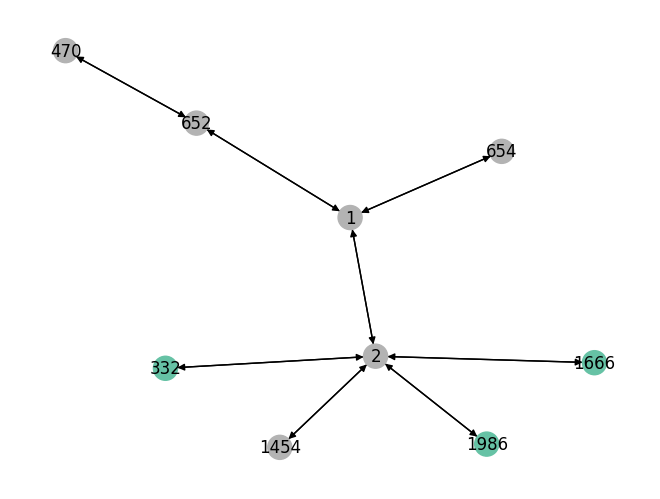

In [10]:

def visualize_hop_neighbor_subgraph(node_idx, data, neighbors, n_hops,adj,feat,label):
    """Visualizes the n-hop neighborhood of a given node."""
    node_idx_new, sub_adj, sub_feat, sub_label, neighbors = extract_neighborhood(node_idx,adj,feat,label,n_hops)
    subdata = data.subgraph(torch.tensor(neighbors))
    subindex = subdata.edge_index
    Gsub = G = to_networkx(subdata, to_undirected=False)
    labeldict = {}
    for i,j in zip(range(len(neighbors)),neighbors):
        labeldict[i] = j
    nx.draw(Gsub, labels = labeldict, node_color = data.y[neighbors], cmap="Set2")
    return subdata, subindex


node_idx = 1
subdata_Data, subindex = visualize_hop_neighbor_subgraph(node_idx, data, neighbors, 2,adj,feat,label)
subdata = subdata_Data.x


2. Get the original label of the node - we already have it 
3. Get the predicted label of the node:

A. Here is where we have to start thinking about the model that we want to explain.
In this next section we will thus implement a very straight - forward GCN model adapted to how the models in GNN explainer have been designed. 

B. Another option implies taking a very straightforward model and then modify the structure of the explainer such that we can actually use that model


For the sake of simplicity we first work on B.

In [25]:
def get_adjacency(data):
    adj = torch.zeros(data.num_nodes, data.num_nodes)
    for edge in data.edge_index.t():
        adj[edge[0]][edge[1]] = 1
    return adj

adj = get_adjacency(data)
#torch.save(adj, 'cora_chk/adj_cora')
adj

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

In [12]:
#DEFINE THE MODEL
class Net(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, output_dim)

    def forward(self, x, adj):
        edge_index = adj.nonzero().t()
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1), adj

In [16]:
#TRAIN THE MODEL

node_idx = 0

#DEFINE THE MODEL
class Net(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, output_dim)

    def forward(self, x, adj):
        edge_index = adj.nonzero().t()
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1), adj
    

    
input_dim = dataset.num_features
output_dim = dataset.num_classes


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(input_dim, output_dim).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)



optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out, adj = model(data.x, get_adjacency(data))  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out, adj = model(data.x, get_adjacency(data))
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_incorrect = pred[data.test_mask] != data.y[data.test_mask] # Check against ground-truth labels.
      
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      torch.save(out, 'cora_chk/prediction_cora')
      return test_acc


for epoch in tqdm(range(1, 401)):
    loss = train()

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}') 


model.eval()
pred, adj = model(data.x, get_adjacency(data))
print(pred)
torch.save(model, 'cora_chk/model_cora')
# torch.save(model.state_dict(),'cora_chk/model_cora_dict' )
# cg_data = {
#       "adj": data["adj"],
#       "feat": data["feat"],
#       "label": data["labels"],
#       "pred": pred.cpu().detach().numpy(),
#       "train_idx": data.train_mask,
# }
#save_checkpoint(model, optimizer, num_epochs=-1, isbest=False, cg_dict=None)

pred, adj = model(data.x, get_adjacency(data))
pred_label = pred.argmax(dim=1)

print(pred_label[data.test_mask])
print(data.y[data.test_mask])
#we will only be interested in the predicted labels for the neighbirhood of the query node
print(f'Predicted labels for node index, {node_idx} with hops {n_hops}: \n ',pred_label[neighbors], 
      f'\n Actual labels for node index, {node_idx} with hops {n_hops}: \n ',data.y[neighbors])


  6%|▌         | 23/400 [00:03<00:58,  6.43it/s]


KeyboardInterrupt: 

In [14]:
pred = torch.load('cora_chk/prediction_cora')
pred_label = pred.argmax(dim=1)
pred_label[data.test_mask]
data.y[data.test_mask]
#print(data.y[data.test_mask])

tensor([3, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2,
        2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 3, 4, 4, 4, 4, 1, 1, 3, 1, 0, 3, 0,
        2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5,
        5, 5, 2, 2, 2, 2, 1, 6, 6, 3, 0, 0, 5, 0, 5, 0, 3, 5, 3, 0, 0, 6, 0, 6,
        3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 4, 4, 4, 0, 3, 3, 2, 5, 5, 5, 5,
        6, 5, 5, 5, 5, 0, 4, 4, 4, 0, 0, 5, 0, 0, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0,
        3, 0, 0, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4,
        6, 6, 5, 6, 6, 3, 5, 5, 5, 0, 5, 0, 4, 4, 3, 3, 3, 2, 2, 1, 3, 3, 3, 3,
        3, 3, 5, 3, 3, 4, 4, 3, 3, 3, 3,

In [15]:
mislabeled = []
correct = []
for i in range(1000):
    if torch.load('cora_chk/prediction_cora').argmax(dim=1)[i] != data.y[i]:
        #print(i, pred_label[i], data.y[i])
        mislabeled.append(i)
    else:
        correct.append(i)
print('mislabeled', mislabeled)    
print('correct',correct)


mislabeled [141, 147, 161, 162, 167, 168, 172, 184, 191, 192, 224, 225, 240, 250, 252, 254, 255, 256, 260, 267, 272, 277, 278, 280, 285, 287, 291, 292, 293, 300, 311, 319, 320, 323, 332, 342, 354, 356, 365, 376, 377, 380, 383, 388, 397, 398, 401, 404, 417, 433, 435, 436, 438, 446, 454, 461, 462, 465, 467, 471, 473, 474, 476, 477, 478, 480, 490, 496, 498, 502, 503, 506, 512, 516, 517, 518, 520, 522, 530, 531, 548, 553, 554, 555, 571, 573, 574, 576, 578, 581, 590, 591, 592, 597, 600, 603, 606, 611, 614, 617, 626, 628, 630, 641, 642, 644, 645, 659, 670, 674, 675, 678, 680, 695, 696, 699, 702, 711, 717, 724, 728, 733, 738, 743, 749, 753, 755, 756, 760, 767, 768, 772, 776, 780, 791, 794, 798, 803, 818, 822, 827, 832, 842, 843, 849, 852, 854, 863, 865, 868, 872, 873, 876, 880, 896, 903, 906, 913, 917, 930, 931, 934, 939, 940, 943, 945, 948, 949, 952, 953, 968, 973, 974, 979, 989, 992, 993, 995]
correct [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,

In [16]:
a = 0
for i,j in zip(data.test_mask, range(len(data.test_mask))):
    if i==True:
        print(j)
        a +=1
a        


1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907


1000

In [17]:
m = []
for i in mislabeled:
    m.append(i+1708)
m

[1849,
 1855,
 1869,
 1870,
 1875,
 1876,
 1880,
 1892,
 1899,
 1900,
 1932,
 1933,
 1948,
 1958,
 1960,
 1962,
 1963,
 1964,
 1968,
 1975,
 1980,
 1985,
 1986,
 1988,
 1993,
 1995,
 1999,
 2000,
 2001,
 2008,
 2019,
 2027,
 2028,
 2031,
 2040,
 2050,
 2062,
 2064,
 2073,
 2084,
 2085,
 2088,
 2091,
 2096,
 2105,
 2106,
 2109,
 2112,
 2125,
 2141,
 2143,
 2144,
 2146,
 2154,
 2162,
 2169,
 2170,
 2173,
 2175,
 2179,
 2181,
 2182,
 2184,
 2185,
 2186,
 2188,
 2198,
 2204,
 2206,
 2210,
 2211,
 2214,
 2220,
 2224,
 2225,
 2226,
 2228,
 2230,
 2238,
 2239,
 2256,
 2261,
 2262,
 2263,
 2279,
 2281,
 2282,
 2284,
 2286,
 2289,
 2298,
 2299,
 2300,
 2305,
 2308,
 2311,
 2314,
 2319,
 2322,
 2325,
 2334,
 2336,
 2338,
 2349,
 2350,
 2352,
 2353,
 2367,
 2378,
 2382,
 2383,
 2386,
 2388,
 2403,
 2404,
 2407,
 2410,
 2419,
 2425,
 2432,
 2436,
 2441,
 2446,
 2451,
 2457,
 2461,
 2463,
 2464,
 2468,
 2475,
 2476,
 2480,
 2484,
 2488,
 2499,
 2502,
 2506,
 2511,
 2526,
 2530,
 2535,
 2540,
 2550,

In [17]:
adj = torch.load('cora_chk/adj_cora')
m = torch.load('cora_chk/masked_adj')
model = torch.load('cora_chk/model_cora')


ypred, adj = model(data.x, adj)
ypred

tensor([[-4.4391, -4.3505, -4.8059,  ..., -3.6707, -5.1621, -5.9049],
        [-4.5603, -5.7525, -5.7548,  ..., -0.0281, -6.1082, -5.8389],
        [-3.6160, -4.4984, -4.7485,  ..., -0.1217, -5.3765, -5.3285],
        ...,
        [-0.9638, -0.9840, -6.8011,  ..., -5.7509, -2.1900, -3.4285],
        [-3.9921, -3.6853, -4.1449,  ..., -2.7006, -4.9017, -5.7876],
        [-3.9293, -3.4936, -3.8329,  ..., -2.8517, -4.5302, -5.4696]],
       grad_fn=<LogSoftmaxBackward0>)

In [19]:
# import os
# def create_filename(save_dir, isbest=False, num_epochs=-1):
#     """
#     Args:
#         args        :  the arguments parsed in the parser
#         isbest      :  whether the saved model is the best-performing one
#         num_epochs  :  epoch number of the model (when isbest=False)
#     """
#     filename = os.path.join(save_dir, 'cora')
#     os.makedirs(filename, exist_ok=True)

#     if isbest:
#         filename = os.path.join(filename, "best")
#     elif num_epochs > 0:
#         filename = os.path.join(filename, str(num_epochs))

#     return filename + ".pth.tar"


# def save_checkpoint(model, optimizer, num_epochs=-1, isbest=False, cg_dict=None):
#     """Save pytorch model checkpoint.

#     Args:
#         - model         : The PyTorch model to save.
#         - optimizer     : The optimizer used to train the model.
#         - args          : A dict of meta-data about the model.
#         - num_epochs    : Number of training epochs.
#         - isbest        : True if the model has the highest accuracy so far.
#         - cg_dict       : A dictionary of the sampled computation graphs.
#     """
#     filename = create_filename('cora_chk', isbest, num_epochs=num_epochs)
#     torch.save(
#         {
#             "epoch": num_epochs,
#             "model_type": 'exp',
#             "optimizer": optimizer,
#             "model_state": model.state_dict(),
#             "optimizer_state": optimizer.state_dict(),
#             "cg": cg_dict,
#         },
#         filename,
#     )


# def load_ckpt( isbest=False):
#     '''Load a pre-trained pytorch model from checkpoint.
#     '''
#     print("loading model")
#     filename = create_filename('cora_chk', isbest=False)
#     print(filename)
#     if os.path.isfile(filename):
#         print("=> loading checkpoint '{}'".format(filename))
#         ckpt = torch.load(filename)
#     else:
#         print("Checkpoint does not exist!")
#         print("Checked path -- {}".format(filename))
#         print("Make sure you have provided the correct path!")
#         print("You may have forgotten to train a model for this dataset.")
#         print()
#         print("To train one of the paper's models, run the following")
#         print(">> python train.py --dataset=DATASET_NAME")
#         print()
#         raise Exception("File not found.")
#     return ckpt

# load_ckpt( isbest=False)

In [20]:
# ckpt = load_ckpt(   isbest=False)
# cg_dict = ckpt["cg"] # get computation graph
# input_dim = cg_dict["feat"].shape[2] 
# num_classes = cg_dict["pred"].shape[2]
# print("Loaded model from {}".format('cora_chk'))
# print("input dim: ", input_dim, "; num classes: ", num_classes)

So now we have the predicted labels for each node stored in pred.
4. Call the ExplainModule into an obejct : we will have to dig in the ExplainModule class before going forward with the explanation of the Explainer module

# Explain Module
inputs: adj, x, model, label 

1. get mask and mask bias -> construct edge_mask (line 656) - in a similar way the feature masks are initialized

->Mask are a torch.nn.parameter.Parameter object randomly initialized with dimension equal to the number of nodes in the neighborhood x number of nodes in the neighborhood (according to different initialization strategies: normal and constant are defined)

Feature mask built in a similar way : the size of the nn.Parameter is the size of the last dimension of x (and thus the number of features for the node)
Diagonal mask is a  tensor of 1s with 0s on the diagonal 

2. Forward function ( line 703 )
Masked adjacency : (_masked_asdj) is the non linear activated mask (sym_mask: it is symmetric because we add its transpose and then divide by 2) multiplied by the adjacency matrix and the diagonal mask (in this way the diagonal elements are 0s out) -> remember that the adjacency matrix we see here is the one of the neighborhood already so the shapes match 
??? So the whole idea about masking is that we perturbate the adjacency matrix  - so that the values inside the matrix are not 0s and 1s but can get different values (according to the initialization)
Then in the forward:
Ypred and adj_att are the model prediction on the node given the masked adjacency matrix (we take the softmax of the node prediction - so the result is a vector of probabilities - and we will be able to inquire how the probability of the correct class change given that we did perturb the graph)

## Mask functions


In [26]:
#Num nodes: is how many nodes in the neighborhood (computed as the sum of 1s over the row of the node of interest - as there is a 1 only if the node is connected to other nodes)

num_nodes = len(neighbors)
diag_mask = torch.ones(num_nodes, num_nodes) - torch.eye(num_nodes) #create a diag mask of 1 and 0s on the diagonal


### Construct mask
Edge and feature masks: initialization of masks

In [27]:
def construct_edge_mask( num_nodes, init_strategy="normal", const_val=1.0):
    """
    Construct edge mask
    input;
        num_nodes: number of nodes in the neighborhood
        init_strategy: initialization strategy for the mask
        const_val: constant value for the mask
    output:
        mask: edge mask    

    """
    torch.manual_seed(42)
    mask = nn.Parameter(torch.FloatTensor(num_nodes, num_nodes))  #initialize the mask
    if init_strategy == "normal":
        std = nn.init.calculate_gain("relu") * math.sqrt(
            2.0 / (num_nodes + num_nodes)
        )
        with torch.no_grad():
            mask.normal_(1.0, std)
    elif init_strategy == "const":
        nn.init.constant_(mask, const_val)
    print(mask.grad)    
    return mask

edge_mask = construct_edge_mask(num_nodes, init_strategy="normal", const_val=1.0)
#edge mask is a matrix of size num_nodes x num_nodes initialized with random values from a normal distribution with mean 1 and std calculated using the formula given 

None


In [28]:
feat_dim = data.num_features
def construct_feat_mask( feat_dim, init_strategy="normal"):
    """
    Construct feature mask
    input:
        feat_dim: dimension of the feature
        init_strategy: initialization strategy
    output:
        mask: feature mask    
    """
    torch.manual_seed(42)
    mask = nn.Parameter(torch.FloatTensor(feat_dim))
    if init_strategy == "normal":
        std = 0.1
        with torch.no_grad():
            mask.normal_(1.0, std)
    elif init_strategy == "constant":
        with torch.no_grad():
            nn.init.constant_(mask, 0.0)
            # mask[0] = 2
    return mask

feat_mask = construct_feat_mask(feat_dim, init_strategy="normal")

#feat mask is a vector of size feat_dim initialized with random values from a normal distribution with mean 1 and std 0.1 (if normal strategy is chosen)

In [29]:
def _masked_adj(mask,adj, diag_mask):
    """ Masked adjacency matrix 
    input: edge_mask, sub_adj, diag_mask
    output: masked_adj
    """
    sym_mask = mask
    sym_mask = torch.sigmoid(mask)
    
    sym_mask = (sym_mask + sym_mask.t()) / 2
    adj = torch.tensor(adj)
    masked_adj = adj * sym_mask

    return masked_adj * diag_mask

masked_adj = _masked_adj(edge_mask,sub_adj, diag_mask)
masked_adj
print('original sub_adj: \n', torch.tensor(sub_adj), '\n masked_adj: \n', masked_adj)


original sub_adj: 
 tensor([[0., 1., 0., 0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [0., 1., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 1., 0., 1., 0., 0.]]) 
 masked_adj: 
 tensor([[0.0000, 0.7511, 0.0000, 0.0000, 0.0000, 0.5748, 0.0000, 0.5617],
        [0.7511, 0.0000, 0.0000, 0.0000, 0.6457, 0.0000, 0.6555, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7299, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7995],
        [0.0000, 0.6457, 0.0000, 0.0000, 0.0000, 0.6385, 0.7203, 0.0000],
        [0.5748, 0.0000, 0.7299, 0.0000, 0.6385, 0.0000, 0.0000, 0.7764],
        [0.0000, 0.6555, 0.0000, 0.0000, 0.7203, 0.0000, 0.0000, 0.0000],
        [0.5617, 0.0000, 0.0000, 0.7995, 0.0000, 0.7764, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_91515/1389454049.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj = torch.tensor(adj)
/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_91515/1389454049.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print('original sub_adj: \n', torch.tensor(sub_adj), '\n masked_adj: \n', masked_adj)


The whole idea of masking the adjacency matrix is to add perturbations in the node connections - they are not connected with the same weights anymore.

### Forward
The method takes several arguments, but the most important one is node_idx, which appears to be the index of a node in a graph. The purpose of this method is to generate a prediction for that node, based on its features and the features of its neighbors, in the form of a softmax output.

The method first checks whether the adjacency matrix should be constrained (i.e. symmetrical) or unconstrained, and generates a masked adjacency matrix accordingly. If the mask_features flag is set, it also masks the input features. If the marginalize flag is set, it generates a random noise vector and scales it according to the feature mask.

The method then passes the masked input features and masked adjacency matrix to a model, which generates a prediction for the target node. If the graph_mode flag is set, it applies a softmax to the entire output, whereas if it is not set, it extracts the prediction for the target node and applies a softmax to that.

Finally, the method returns the softmax output and the adjacency matrix attention, which may be used for visualization or analysis purposes.

Here we are just exploring how the prediction works if we only consider the subadjacency and the subgraph 


Ok so now we have to use the simplified version of this fancy more to make some training ---> then we want to try and explain this trained boy with the GNN Explainer simplified method. 


Let's see if everything will work out well :)

### Forward loop! and how the loss works


#### LOSS
The loss is - as for any ML task - our objective function that we want to minimize during training.

#### many y!!
Some notation to understand better what's going on.
- y : ground thruth label value
- y_hat : prediction of the label value made by the original model (that has access to the full graph)
- y_e : prediction of the label value made on the sub_graph - (this gets update according to how the masked adjacency matrix gets updated)


#### Losses
- PRED LOSS: encourage y_e to be close to y_hat
- MASK EDGE SIZE LOSS: encourage the mask to have the least amount of edges
- MASK FEATURE SIZE LOSS: // of features
- MASK EDGE ENTROPY LOSS: encourage the model to have a balanced level of uncertainty
- MASK FEATURE ENTROPY LOSS
- LAPLACIAN LOSS: encourage the smoothness of the mask over the graph 

In [30]:
#FUNCTIONS THAT WE USE IN THE EXPLAIN.PY FILE

def loss_fc(edge_mask, feat_mask, masked_adj,adj, pred, pred_label,label, node_idx, epoch, print=False):
    """
    Args:
        pred: y_e :  prediction made by current model
        pred_label: y_hat : the label predicted by the original model.
    """
    #PRED LOSS
    pred_label_node = pred_label[node_idx] #pred label is the prediction made by the original model
    gt_label_node = label[node_idx]

    logit = pred[gt_label_node] #pred is the prediction made by the current model

    pred_loss = -torch.log(logit) #this is basically taking the cross entropy loss

    # MASK SIZE EDGE LOSS
    
    mask = edge_mask


    mask = torch.sigmoid(mask)

    size_loss = 0.005 * torch.sum(mask)

    
    #MASK SIZE FEATURE LOSS
    feat_mask = (torch.sigmoid(feat_mask))
    feat_size_loss = 1.0 * torch.mean(feat_mask)

    # EDGE MASK ENTROPY LOSS
    mask_ent = -mask * torch.log(mask) - (1 - mask) * torch.log(1 - mask)
    mask_ent_loss = 1.0 * torch.mean(mask_ent)
    
    # FEATURE MASK ENTROPY LOSS
    feat_mask_ent = - feat_mask * torch.log(feat_mask) - (1 - feat_mask) * torch.log(1 - feat_mask)

    feat_mask_ent_loss = 0.1  * torch.mean(feat_mask_ent)

    # LAPLACIAN LOSS
    D = torch.diag(torch.sum(masked_adj, 0))
    m_adj = masked_adj 
    L = D - m_adj

    pred_label_t = torch.tensor(pred_label, dtype=torch.float)


    lap_loss = ( 1.0
        * (pred_label_t @ L @ pred_label_t)
        / torch.Tensor(adj).numel())


    loss = pred_loss + size_loss  + mask_ent_loss + feat_size_loss + lap_loss
    if print== True:
        print("optimization/size_loss", size_loss, epoch)
        print("optimization/feat_size_loss", feat_size_loss, epoch)
        print("optimization/mask_ent_loss", mask_ent_loss, epoch)
        print(
            "optimization/feat_mask_ent_loss", mask_ent_loss, epoch
        )

        print("optimization/pred_loss", pred_loss, epoch)
        print("optimization/lap_loss", lap_loss, epoch)
        print("optimization/overall_loss", loss, epoch)
    return loss




#SEE how the loss function is used in the explain.py file
pred_label = torch.load('cora_chk/prediction_cora') #load prediction of original model
pred_label = torch.argmax(pred_label[neighbors], dim=1) #get the prediction of the query node
adj = torch.load('cora_chk/adj_cora') #load the adjacency matrix of the original model
model = torch.load('cora_chk/model_cora') #load the original model

#We are using the original model to get the prediction of the query node
pred, adj = model.forward(torch.Tensor(subdata), torch.Tensor(sub_adj))
node_pred = pred[node_idx_new, :] #get the prediction of the query node
pred = nn.Softmax(dim=0)(node_pred) #apply softmax to it
loss_fc( edge_mask, feat_mask, masked_adj,adj, pred, pred_label,data.y, node_idx, 1)

NameError: name 'subdata' is not defined

In [26]:
def construct_diag_mask(neighbors):
    """
    Args:
        adj: adjacency matrix of the graph
    """
    num_nodes = len(neighbors)
    diag_mask = torch.ones(num_nodes, num_nodes) - torch.eye(num_nodes) 

    return diag_mask

construct_diag_mask(neighbors)

tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0.]])

In [27]:
def mask_density(edge_mask):
    """
    Args:
        mask: edge mask
    """
    mask = torch.sigmoid(edge_mask)
    return torch.sum(mask) / torch.Tensor(mask).numel()

mask_density(edge_mask)

tensor(0.7236, grad_fn=<DivBackward0>)

In [28]:
def log_adj_grad(adj, masked_adj, node_idx, pred_label,pred_label_node, x, epoch, label=None):
    """ 
    Computes the gradient of the adjacency matrix with respect to the loss
    
    """
    log_adj = False

    predicted_label = pred_label
    # adj_grad = torch.abs(self.adj_feat_grad(node_idx, predicted_label)[0])[self.graph_idx]
    adj_grad, x_grad = adj_feat_grad(node_idx, pred_label_node, model , adj,x)
    print('adj_grad: ', adj_grad)
    adj_grad = torch.abs(adj_grad)
    x_grad = x_grad[node_idx][:, np.newaxis]
        # x_grad = torch.sum(x_grad[self.graph_idx], 0, keepdim=True).t()
    adj_grad = (adj_grad + adj_grad.t()) / 2
    adj_grad = (adj_grad * adj).squeeze()


    masked_adj = masked_adj[0].cpu().detach().numpy()
    return masked_adj

In [29]:
def adj_feat_grad(node_idx, pred_label_node, model , adj,x, ):
    """
    Compute the gradient of the prediction w.r.t. the adjacency matrix
    and the node features.
    """
    model.zero_grad()
    adj.requires_grad = True
    x.requires_grad = True
    print('adj',adj)
    if adj.grad is not None:
        adj.grad.zero_() # zero out the gradient
        x.grad.zero_() # zero out the gradient

    x, adj = x, adj
    ypred, _ = model(x, adj)

    logit = nn.Softmax(dim=0)(ypred[ node_idx, :])
    logit = logit[pred_label_node]
    loss = -torch.log(logit)
    loss.backward()
    return adj.grad, x.grad

In [30]:
pred_label = torch.load('cora_chk/prediction_cora')
pred_label = torch.argmax(pred_label[neighbors], dim=1)

pred_label_node = pred_label[node_idx]
adj = torch.load('cora_chk/adj_cora')
x = data.x
adj_feat_grad(node_idx, pred_label_node, model , adj,x, )
#log_adj_grad(adj, masked_adj, node_idx, pred_label,pred_label_node, x, 1, label=None)

adj tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]], requires_grad=True)


(None,
 tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [6.5486e-04, 2.6171e-03, 1.5889e-02,  ..., 8.0785e-03, 2.8308e-03,
          5.5990e-03],
         [1.3034e-04, 3.9236e-05, 4.1168e-03,  ..., 1.8827e-03, 5.9122e-05,
          1.2444e-03],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]))

#### Explain
In order to make our life easier for what concerns training we wrap up all the functions that we defined so far in a class - Explain.

In addition to the existing funtion we define a forward, that basically just perform a forward using the already trained model using the data of the neighborhood of interest only (namely subdata and a sub-adjacency matrix - in the paper those are called as G_c and A_c)

The goal that we want to achieve with training via backpropagation on the predefined loss is to find G_s and A_s (as referenced in the paper) such that we can maximize the MUTUAL information.

--> Explanation for prediction yˆ is thus a subgraph GS that minimizes uncertainty of Φ when the GNN computation is limited to GS. 

We also define 



In [31]:
class Explain(nn.Module):
    def __init__(self, model, data, node_idx, n_hops):
        super(Explain, self).__init__()
        #Those are the parameters of the original data and model
        self.model = model
        self.data = data
        self.node_idx = node_idx
        self.n_hops = n_hops
        self.adj = get_adjacency(data)
        self.label = torch.Tensor(data.y)
        self.feat = torch.Tensor(data.x)
        self.feat_dim = data.num_features
        self.epoch = 1
        self.x = data.x

        self.pred_label = torch.load('cora_chk/prediction_cora')

        self.node_idx_new, self.sub_adj, self.sub_feat, self.sub_label, self.neighbors = extract_neighborhood(self.node_idx, self.adj, self.feat, self.label, self.n_hops)
        self.num_nodes = len(self.neighbors)
        self.diag_mask = construct_diag_mask(self.neighbors)
        self.subdata = torch.Tensor(data.subgraph(torch.tensor(self.neighbors)).x)
        self.edge_mask = construct_edge_mask(self.num_nodes)
        self.feat_mask = construct_feat_mask(self.feat_dim, init_strategy="normal")



    
    def _masked_adj(self):
        """ Masked adjacency matrix 
        input: edge_mask, sub_adj, diag_mask
        output: masked_adj
        """
        sym_mask = self.edge_mask
        sym_mask = torch.sigmoid(sym_mask)
        
        sym_mask = (sym_mask + sym_mask.t()) / 2
        adj = torch.tensor(self.sub_adj)
        masked_adj = adj * sym_mask

        return masked_adj * self.diag_mask
    
        
        
    def forward(self):
        """
        Returns:
            ypred: prediction of the query node made by the current model (on the subgraph)

        """

        self.masked_adj = self._masked_adj()
        print(self.edge_mask)
        feat_mask = (torch.sigmoid(self.feat_mask))
        x = self.sub_feat * feat_mask
        #ypred, adj_att = model(self.subdata, masked_adj)
        ypred, adj_att = self.model(x, self.masked_adj)
        node_pred = ypred[self.node_idx_new, :]
        res = nn.Softmax(dim=0)(node_pred)
        return res, adj_att, self.sub_adj
    
    def criterion(self, epoch):
        """
        Computes the loss of the current model
        """
        #prediction of explanation model
        pred, adj_e, sub_adj = self.forward()

        #prediction of original model
        pred_label = torch.argmax(self.pred_label[self.neighbors], dim=1)


        loss_val = loss_fc(self.edge_mask, self.feat_mask, self.masked_adj,self.adj, pred, pred_label, self.label,self.node_idx, self.epoch)

        return loss_val 
    
    def mask_density(self):
        """
        Computes the density of the edge mask
        """
        mask_sum = torch.sum(self.masked_adj)
        adj_sum = torch.sum(self.adj)
        return mask_sum / adj_sum
    
    def return_stuff(self):
        pred_label = torch.argmax(self.pred_label[self.neighbors], dim=1)
        return pred_label[self.node_idx], self.label[self.node_idx], self.neighbors, self.sub_label, self.sub_feat, self.n_hops
    
    def log_adj_grad(self, node_idx, pred_label, epoch, label=None):
        """ 
        Computes the gradient of the adjacency matrix with respect to the loss
        
        """
        log_adj = False

        predicted_label = pred_label
        # adj_grad = torch.abs(self.adj_feat_grad(node_idx, predicted_label)[0])[self.graph_idx]
        adj_grad, x_grad = self.adj_feat_grad(node_idx, predicted_label)
        adj_grad = torch.abs(adj_grad)
        x_grad = x_grad[node_idx][:, np.newaxis]
            # x_grad = torch.sum(x_grad[self.graph_idx], 0, keepdim=True).t()
        adj_grad = (adj_grad + adj_grad.t()) / 2
        adj_grad = (adj_grad * self.adj).squeeze()


        masked_adj = self.masked_adj[0].cpu().detach().numpy()


    

        adj_grad = adj_grad.detach().numpy()

    def adj_feat_grad(self, node_idx, pred_label_node):
        """
        Compute the gradient of the prediction w.r.t. the adjacency matrix
        and the node features.
        """
        self.model.zero_grad()
        self.adj.requires_grad = True
        self.x.requires_grad = True
        if self.adj.grad is not None:
            print('self.adj.grad', self.adj.grad)
            self.adj.grad.zero_() # zero out the gradient
            self.x.grad.zero_() # zero out the gradient

        else:
            x, adj = self.x, self.adj
        ypred, _ = self.model(x, adj)


        logit = nn.Softmax(dim=0)(ypred[ node_idx, :])
        logit = logit[pred_label_node]
        loss = -torch.log(logit)
        loss.backward()
        print('adj grad', self.adj.grad)
        print('x grad',self.x.grad)
        return self.adj, self.x.grad    
    


### Create the explain object
Here we create the explain object and we specify the node to explain and how big we consider its neighborhood to be 

In [32]:
explainer = Explain(model = torch.load('cora_chk/model_cora'), data = data, node_idx = 0, n_hops=2)
optimizer = torch.optim.Adam(explainer.parameters(), lr=0.01)

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_5019/2699400499.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj = torch.tensor(adj, dtype=torch.float)


None


### TRAINING LOOP
Here we perform the training loop:
- zero out explainer and optimizer
- forward on subgraph model
- loss and backprop
- optimizer step

In [33]:
explainer.train()
for epoch in range(100):
    explainer.zero_grad()
    optimizer.zero_grad()
    ypred, adj_atts, sub_adj = explainer.forward()
    loss = explainer.criterion(epoch)
    pred_label, original_label, neighbors, sub_label, sub_feat, num_hops = explainer.return_stuff()
    



    loss.backward(retain_graph=True)
    optimizer.step()
    mask_density = explainer.mask_density()
    single_subgraph_label = sub_label.squeeze()
    if epoch % 25 == 0:
    # #     explainer.log_mask(epoch)
    # #     explainer.log_masked_adj(
    # #         node_idx_new, epoch, label=single_subgraph_label
    # #     )


        explainer.log_adj_grad(
            node_idx_new, pred_label, epoch, label=single_subgraph_label)



    if epoch % 10 == 0:

        print(
        "epoch: ",
        epoch,
        "; loss: ",
        loss.item(),
        "; mask density: ",
        mask_density.item(),
        "; pred: ",
        ypred,
        "; labels equal: ",
        torch.argmax(ypred) == original_label== pred_label,

    )


adj_atts = torch.sigmoid(adj_atts).squeeze()
masked_adj = adj_atts * sub_adj.squeeze()
masked_adj

Parameter containing:
tensor([[ 1.9635,  1.7436,  1.4504, -0.0528,  1.3392,  0.3827,  0.9785,  0.1977],
        [ 0.6239,  1.8244,  0.8038,  0.2982,  0.6361,  0.7203,  0.6156,  1.3812],
        [ 1.8212,  0.9202,  0.7513,  1.2198,  0.6209,  1.5392,  1.4004,  1.8403],
        [ 1.6396,  1.6482,  1.3052,  1.6674,  0.8842,  1.0209,  0.8742,  1.4299],
        [ 0.3077,  0.5644,  0.8883,  1.8587,  1.1594,  0.7877,  1.1529,  0.6127],
        [ 0.2212,  1.4978,  0.5601,  0.6994,  0.3629,  2.0614,  0.3827,  0.7560],
        [ 0.5431,  0.6709,  1.0390,  1.2629,  0.7560,  1.5957,  0.5930,  0.6320],
        [ 0.2984,  1.0180,  0.9683,  1.3378,  0.9511,  1.9223,  0.4077,  1.6918]],
       requires_grad=True)
Parameter containing:
tensor([[ 1.9635,  1.7436,  1.4504, -0.0528,  1.3392,  0.3827,  0.9785,  0.1977],
        [ 0.6239,  1.8244,  0.8038,  0.2982,  0.6361,  0.7203,  0.6156,  1.3812],
        [ 1.8212,  0.9202,  0.7513,  1.2198,  0.6209,  1.5392,  1.4004,  1.8403],
        [ 1.6396,  1.6482,

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_5019/3195031680.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj = torch.tensor(self.sub_adj)
/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_5019/507372444.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label_t = torch.tensor(pred_label, dtype=torch.float)


Parameter containing:
tensor([[ 2.0035,  1.7836,  1.4904, -0.0928,  1.3792,  0.4228,  1.0185,  0.1576],
        [ 0.6640,  1.8644,  0.8438,  0.2585,  0.6761,  0.7603,  0.6556,  1.4212],
        [ 1.8612,  0.9602,  0.7913,  1.2598,  0.6610,  1.5792,  1.4404,  1.8803],
        [ 1.6796,  1.6882,  1.3452,  1.7074,  0.9242,  1.0609,  0.9142,  1.4699],
        [ 0.2685,  0.6044,  0.9283,  1.8987,  1.1995,  0.8278,  1.1929,  0.6528],
        [ 0.1811,  1.5378,  0.6002,  0.7395,  0.4030,  2.1014,  0.4228,  0.7961],
        [ 0.5832,  0.7110,  1.0790,  1.3029,  0.7960,  1.6357,  0.6331,  0.6721],
        [ 0.2587,  1.0580,  1.0083,  1.3778,  0.9911,  1.9623,  0.4478,  1.7318]],
       requires_grad=True)
Parameter containing:
tensor([[ 2.0035,  1.7836,  1.4904, -0.0928,  1.3792,  0.4228,  1.0185,  0.1576],
        [ 0.6640,  1.8644,  0.8438,  0.2585,  0.6761,  0.7603,  0.6556,  1.4212],
        [ 1.8612,  0.9602,  0.7913,  1.2598,  0.6610,  1.5792,  1.4404,  1.8803],
        [ 1.6796,  1.6882,

tensor([[0.0000, 0.7100, 0.0000, 0.0000, 0.0000, 0.6336, 0.0000, 0.5644],
        [0.7100, 0.0000, 0.0000, 0.0000, 0.7011, 0.0000, 0.7018, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7083, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7139],
        [0.0000, 0.7011, 0.0000, 0.0000, 0.0000, 0.7011, 0.7071, 0.0000],
        [0.6336, 0.0000, 0.7083, 0.0000, 0.7011, 0.0000, 0.0000, 0.7121],
        [0.0000, 0.7018, 0.0000, 0.0000, 0.7071, 0.0000, 0.0000, 0.0000],
        [0.5644, 0.0000, 0.0000, 0.7139, 0.0000, 0.7121, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)

### VISUALIZATION 
We visualize the output according to how strong the model has imputed the connections between the nodes of the neighborhood to be for the sake of prediction of the node of interest

[0.71004957, 0.6336027, 0.56436, 0.70113933, 0.7018184, 0.70832366, 0.71390694, 0.70113397, 0.707074, 0.71207166]


/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_5019/2378129677.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


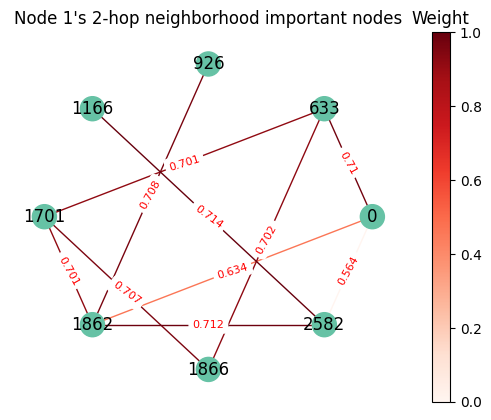

In [34]:
def visualize_result(node_idx, masked_adj, neighbors, data, num_hops):
    """Visualizes the n-hop neighborhood of a given node."""
    G = nx.from_pandas_adjacency(pd.DataFrame(masked_adj.detach().numpy()))

    labeldict = {}
    for i,j in zip(range(len(neighbors)),neighbors):
        labeldict[i] = j
    #print(labeldict)    
    a = nx.get_edge_attributes(G,'weight')
    weights = {key : round(a[key], 3) for key in a}

    edge_colors = [masked_adj.detach().numpy()[u][v] for u, v in G.edges()]
    print(edge_colors)
    # draw graph with edge colors
    plt.figure()  
    plt.title("Node {}'s {}-hop neighborhood important nodes".format(node_idx, num_hops))
    pos = nx.circular_layout(G)
    nx.draw(G, pos=pos, with_labels=True, edge_color=edge_colors, edge_cmap=plt.cm.Reds,labels = labeldict, node_color = data.y[neighbors], cmap="Set2" )
    nx.draw_networkx_edge_labels( G, pos,edge_labels=weights,font_size=8,font_color='red')

    # add colorbar legend
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array(edge_colors)
    cbar = plt.colorbar(sm)
    cbar.ax.set_title('Weight')

    plt.show()  

visualize_result(1, masked_adj, neighbors,data,num_hops)    

In [36]:

%matplotlib inline

from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import os
from tqdm import tqdm, trange

import matplotlib.pyplot as plt

In [37]:
#Load the dataset
dataset = 'cora'
path = os.path.join(os.getcwd(), 'data', 'Planetoid')
train_dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())

# Since the dataset is comprised of a single huge graph, we extract that graph by indexing 0.
data = train_dataset[0]

# Since there is only 1 graph, the train/test split is done by masking regions of the graph. We split the last 500+500 nodes as val and test, and use the rest as the training data.
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:data.num_nodes - 1000] = 1
data.val_mask = None
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[data.num_nodes - 500:] = 1

In [38]:
class Net(torch.nn.Module):
    def __init__(self, num_features, dim=16, num_classes=1):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_features, dim)
        self.conv2 = GCNConv(dim, num_classes)

    def forward(self, x, edge_index, data=None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [39]:
epochs = 200
dim = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=train_dataset.num_features, dim=dim, num_classes=train_dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)
def test(model, data):
    model.eval()
    logits, accs = model(data.x, data.edge_index, data), []
    for _, mask in data('train_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [40]:
loss = 999.0
train_acc = 0.0
test_acc = 0.0

t = trange(epochs, desc="Stats: ", position=0)

for epoch in t:

    model.train()
    
    loss = 0

    data = data.to(device)
    optimizer.zero_grad()
    log_logits = model(data.x, data.edge_index, data)

    # Since the data is a single huge graph, training on the training set is done by masking the nodes that are not in the training set.
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # validate
    train_acc, test_acc = test(model, data)
    train_loss = loss
    
    t.set_description('[Train_loss:{:.6f} Train_acc: {:.4f}, Test_acc: {:.4f}]'.format(loss, train_acc, test_acc))

[Train_loss:1.582890 Train_acc: 0.4274, Test_acc: 0.4380]: 100%|██████████| 200/200 [00:05<00:00, 34.36it/s]


In [41]:
node_idx = 0
x, edge_index = data.x, data.edge_index
explainer = GNNExplainer(model)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'nn.models.GNNExplainer' is deprecated, use 'explain.Explainer' with 'explain.algorithm.GNNExplainer' instead
  warnings.warn(out)


In [42]:
len(edge_mask)
data.edge_index.shape
edge_mask[neighbors]
neighbors

edge_mask

tensor([0.7415, 0.7423, 0.7553,  ..., 0.0000, 0.0000, 0.0000])

In [43]:
ypred = model(data.x, edge_mask.unsqueeze(1), data)
ypred

IndexError: tensors used as indices must be long, byte or bool tensors

In [ ]:
edge_mask.to_sparse()
indices = edge_mask.to_sparse().indices()
# indices
#data.edge_index
edge_mask.to_sparse().values()
i = data.edge_index.t()[indices].squeeze().t()
v = edge_mask.to_sparse().values()
e = torch.sparse_coo_tensor(i ,v )

In [ ]:

e = torch.sparse_coo_tensor(i ,v )
e

In [ ]:
for i in data.edge_index.t():
    if 0 in i :
        print(i)
#data.edge_index[0]

In [ ]:
def find_n_hop_neighbors(edge_index, n, node=None):
    """ 
    edge_index 
    n = num hops
    node = node_idx
    """
    # create dictionary of node neighborhoods
    neighborhoods = {}
    for i in range(edge_index.max().item() + 1):
        neighborhoods[i] = set()

    # find 1-hop neighbors and corresponding edges
    edges = []
    for j in range(edge_index.shape[1]):
        src, dst = edge_index[0, j].item(), edge_index[1, j].item()
        neighborhoods[src].add(dst)
        neighborhoods[dst].add(src)
        edges.append((src, dst))

    # find n-hop neighbors for the specified node or all nodes

    for k in range(2, n+1):
        new_neighbors = set()
        for neighbor in neighborhoods[node]:
            new_neighbors.update(neighborhoods[neighbor])
        neighborhoods[node].update(new_neighbors)
    sub_edges = []
    for edge in edges:
        src, dst = edge
        if src in neighborhoods[node] and dst in neighborhoods[node] or src == node or dst == node:
            sub_edges.append(edge)
            
    sub_edges_tensor = torch.tensor([sub_edges[i] for i in range(len(sub_edges))]).t()        

    #return {node: sub_edges}, {node: neighborhoods[node]}, sub_edges_tensor
    return sub_edges, neighborhoods[node], sub_edges_tensor 

sub_edges, neighborhoods, sub_edges_tensor = find_n_hop_neighbors(data.edge_index, 2, node=0)

In [ ]:
neighborhoods

In [ ]:
data.edge_index.t()[indices] == sub_edges_tensor.t()